## Import Necessary Libaries and Define a Few Helper Functions

In [1]:
import os
import openai
import itertools
import random

import requests
import uuid
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
import math
openai.api_key =  os.environ["OPENAI_API_KEY"]
openai.Model.list()
# Functions
def ask_gpt(prompt):
    response = openai.Completion.create(
        engine="text-davinci-003",  # use the latest model available to you
        prompt=prompt,
        max_tokens=200, 
    )
    output_text_parsed = response.choices[0].text.strip()
    print(output_text_parsed)
    return response
# make a uniqueish string to label images as they are generated
def generate_uniqueish_string():
    return str(uuid.uuid4())[:8]

def process_dalle_images(response, filename, image_dir, i, hash = True):
    # save the images
    uid = generate_uniqueish_string()
    urls = [datum["url"] for datum in response["data"]]  # extract URLs
    images = [requests.get(url).content for url in urls]  # download images
    image_names = [f"{filename}_{i + 1}_{uid}.png" for j in range(len(images))]  # create names
    filepaths = [os.path.join(image_dir, name) for name in image_names]  # create filepaths
    for image, filepath in zip(images, filepaths):  # loop through the variations
        with open(filepath, "wb") as image_file:  # open the file
            image_file.write(image)  # write the image to the file

    return filepaths
# set a directory to save DALL·E images to
image_dir_name = "images"
image_dir = os.path.join(os.curdir, image_dir_name)

# create the directory if it doesn't yet exist
if not os.path.isdir(image_dir):
    os.mkdir(image_dir)

# print the directory to save to
print(f"{image_dir=}")
def top_half_mask(width, height, mask_dir, mask_name):
    mask = Image.new("RGBA", (width, height), (0, 0, 0, 1))
    for x in range(width):
        for y in range(height // 2):
            mask.putpixel((x, y), (0, 0, 0, 0))
    mask_filepath = os.path.join(mask_dir, mask_name)
    mask.save(mask_filepath)

def full_mask(width, height, mask_dir, mask_name):
    # Create a new image with RGBA mode (includes transparency)
    mask = Image.new("RGBA", (width, height), (0, 0, 0, 1)) # The last number is the alpha channel. 255 = opaque

    # Save the mask image
    mask_filepath = os.path.join(mask_dir, mask_name)
    mask.save(mask_filepath)

def bottom_half_mask(width, height, mask_dir, mask_name):
    mask = Image.new("RGBA", (width, height), (0, 0, 0, 1))
    for x in range(width):
        for y in range(height // 2, height):
            mask.putpixel((x, y), (0, 0, 0, 0))
    mask_filepath = os.path.join(mask_dir, mask_name)
    mask.save(mask_filepath)

def left_half_mask(width, height, mask_dir, mask_name):
    mask = Image.new("RGBA", (width, height), (0, 0, 0, 1))
    for x in range(width // 2):
        for y in range(height):
            mask.putpixel((x, y), (0, 0, 0, 0))
    mask_filepath = os.path.join(mask_dir, mask_name)
    mask.save(mask_filepath)

def right_half_mask(width, height, mask_dir, mask_name):
    mask = Image.new("RGBA", (width, height), (0, 0, 0, 1))
    for x in range(width // 2, width):
        for y in range(height):
            mask.putpixel((x, y), (0, 0, 0, 0))
    mask_filepath = os.path.join(mask_dir, mask_name)
    mask.save(mask_filepath)


def create_circular_mask(width, height, mask_dir, mask_name, coverage):
    # Create a new image with RGBA mode (includes transparency)
    mask = Image.new("RGBA", (width, height), (0, 0, 0, 0)) # Start with fully transparent mask
    draw = ImageDraw.Draw(mask)
    
    total_area = width * height
    coverage_area = coverage * total_area
    current_area = 0
    
    while current_area < coverage_area:
        # Randomly generate the circle parameters
        radius = random.randint(1, min(width, height) // 2)
        center_x = random.randint(radius, width - radius)
        center_y = random.randint(radius, height - radius)
        
        # Draw the circle on the mask
        bounding_box = [center_x - radius, center_y - radius, center_x + radius, center_y + radius]
        draw.ellipse(bounding_box, fill=(0, 0, 0, 1)) # (0, 0, 0, 255) = opaque black
        
        # Update the current area
        current_area += math.pi * radius ** 2

    # Save the mask image
    mask_filepath = os.path.join(mask_dir, mask_name)
    mask.save(mask_filepath)

image_dir='./images'


## Show Image we are working with

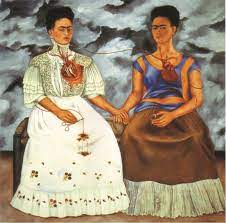

In [2]:
image_to_edit = "images/American_Gothic_Square.png"
image_to_edit = "images/nuggets.jpg"
image_to_edit = "images/twofridas.jpeg"
im = Image.open(image_to_edit)
display(im)

showing cropped png


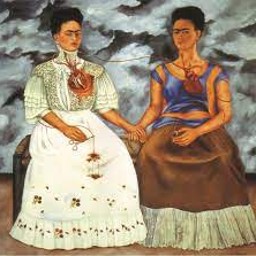

In [3]:
# crop image: 
def load_and_crop_image(image_path, desired_size):
    # Load the image
    img = Image.open(image_path)

    # Calculate the crop parameters
    width, height = img.size   # Get dimensions
    min_dim = min(width, height)

    # Calculate the area to be cropped
    left = (width - min_dim)/2
    top = (height - min_dim)/2
    right = (width + min_dim)/2
    bottom = (height + min_dim)/2

    # Crop the image
    img_cropped = img.crop((left, top, right, bottom))

    # Resize the image to the desired size
    img_square = img_cropped.resize((desired_size, desired_size))

    return img_square

# Usage
image_path = image_to_edit  # change this to your image path
desired_size = 256  # change this to your desired size
square_image = load_and_crop_image(image_path, desired_size)


def write_image_as_png(img, original_image_path):
    # Create new file path by replacing the old file extension with .png
    new_path = original_image_path.rsplit('.', 1)[0] + ".png"
    img.save(new_path)
    return(new_path)

# Usage
square_image = load_and_crop_image(image_path, desired_size)
square_png_path = write_image_as_png(square_image, image_path)
im = Image.open(square_png_path)
print("showing cropped png")
display(im)




## Use GPT-3 to generate a list of art styles to remix American Gothic

In [4]:
# The question you want to ask GPT-3
question = "provide a python list of 15 distinct art styles (i.e. impressionist, cubist, pointlist, photorealistic, japanese wood block print)"
# Join the description and question into a single string
prompt = f"{question}"
gpt_output = ask_gpt(prompt)
# Parse the output
art_styles_string = gpt_output.choices[0]['text']
art_styles = [line.split('. ')[1] for line in art_styles_string.split('\n') if line]
# choose the length of combinations you want, for example 2
length_of_combinations = 2
style_combinations = list(itertools.combinations(art_styles, length_of_combinations))

1. Expressionism
2. Impressionism 
3. Cubism
4. Surrealism
5. Minimalism
6. Fauvism
7. Pointillism
8. Photorealism
9. Neoclassicism
10. Pop Art
11. Baroque
12. Abstractionism
13. Japanese Woodblock Print
14. Dadaism
15. Conceptual Art


In [5]:
# Format the GPT output for Dalle prompt
formatted_strings = []

for combination in style_combinations:
    style_1, style_2 = combination
    formatted_string = f"in the style of {style_1} and {style_2}"
    formatted_strings.append(formatted_string)

for string in formatted_strings[:10]:
    print(string)


in the style of Expressionism and Impressionism 
in the style of Expressionism and Cubism
in the style of Expressionism and Surrealism
in the style of Expressionism and Minimalism
in the style of Expressionism and Fauvism
in the style of Expressionism and Pointillism
in the style of Expressionism and Photorealism
in the style of Expressionism and Neoclassicism
in the style of Expressionism and Pop Art
in the style of Expressionism and Baroque


## Create Masks


In [6]:
edit_dir_name = image_to_edit.split("/")[-1].split(".")[0]

In [7]:
mask_dir = "images/masks"
# create the directory if it doesn't yet exist
if not os.path.isdir(mask_dir):
    os.mkdir(mask_dir)
# print the directory to save to
print(f"{mask_dir=}")

# TODO ask what are the actual image sizes 
width = 256
height = 256

mask_dir = "./masks"
os.makedirs(mask_dir, exist_ok=True)  # ensure the directory exists
top_half_mask(width, height, mask_dir, "top_half_mask.png")
bottom_half_mask(width, height, mask_dir, "bottom_half_mask.png")
left_half_mask(width, height, mask_dir, "left_half_mask.png")
right_half_mask(width, height, mask_dir, "right_half_mask.png")
full_mask(width, height, mask_dir, "full_mask.png")
coverage = 0.8  # Coverage of the mask (0.5 = 50%)
create_circular_mask(width, height, mask_dir, f"circle_mask_{coverage}.png", coverage)
# specify edit images dir
edit_image_dir = os.path.join("images", "edits", edit_dir_name)

mask_dir='images/masks'


In [8]:
os.makedirs(f"{edit_image_dir}", exist_ok=True)

## Call DALE API using a random mask of the 4 halves of the image, and a random combination of styles

In [9]:
# TODO: find best way to add style tags to generated images in their metadata or just their filename

# Specify the directory
mask_dir = "./masks/"
num_iterations = 3  # specify the number of iterations

# Get the list of all masks in the directory
masks = [f for f in os.listdir(mask_dir) if f.startswith('b')]


In [10]:

# Iterate for the number of specified iterations
for i in range(num_iterations):
    # Select a random mask
    selected_mask = random.choice(masks)
    # Get the full file path of the selected mask
    mask_filepath = os.path.join(mask_dir, selected_mask)

    # Select a random style combination
    selected_prompt = random.choice(formatted_strings)

    edit_response = openai.Image.create_edit(
        image=open(square_png_path, "rb"),  # local american gothic image
        mask=open(mask_filepath, "rb"),  # from right above
        prompt=selected_prompt,  # from the generation section
        n=1,
        size="256x256",
        response_format="url",
    )
    
    # print response for prototype / debug
    # print(edit_response)
    edit_filepaths = process_dalle_images(edit_response, "edits", edit_image_dir, i, hash = True)


## Plot the generated images in a collage

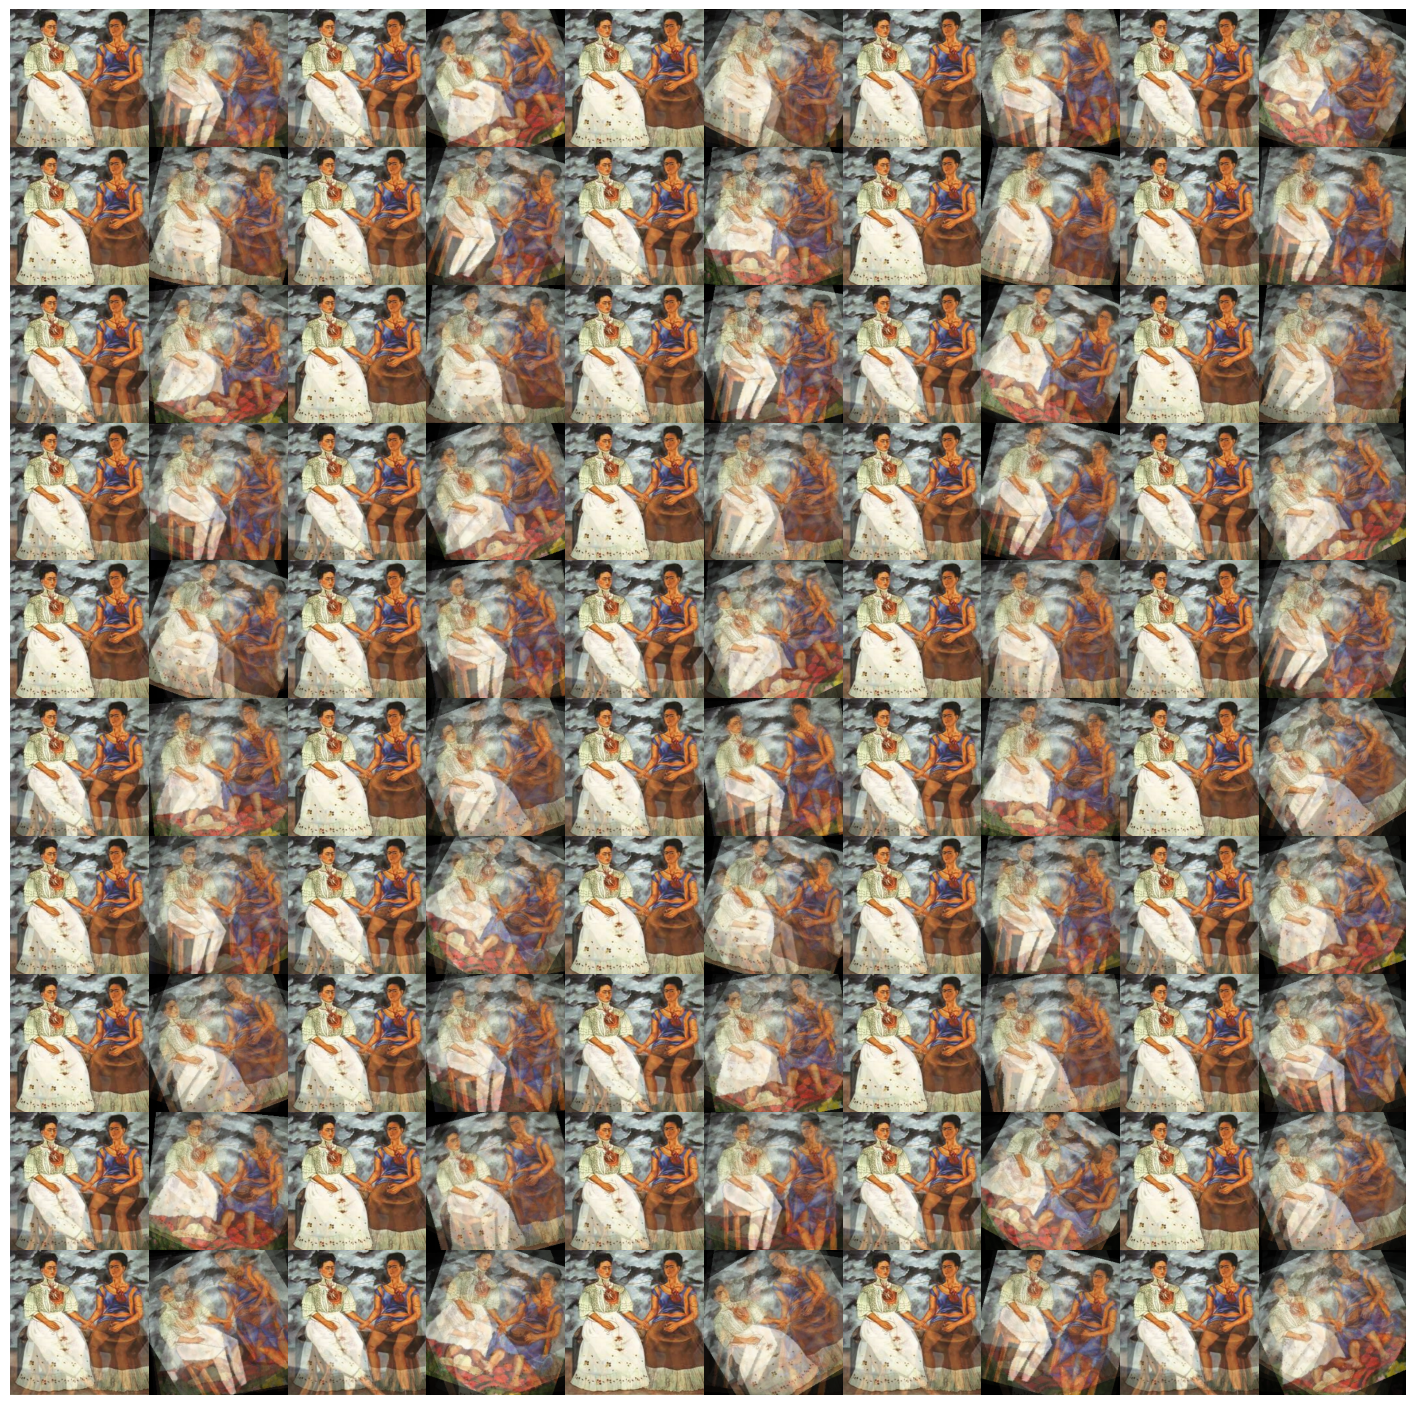

In [11]:


def plot_images(num_images, edit_image_dir, rotation):
    # Specify the directory
    image_directory = edit_image_dir + "/"
    image_files = [f for f in os.listdir(image_directory) if f.endswith('.png')]
    
    # shuffle image file order to get different images in the plot
    np.random.shuffle(image_files)
    
    # Load all the images
    images = [Image.open(image_directory + f) for f in image_files]
    
    # Repeat the list of images to ensure we have enough to plot
    while len(images) < num_images:
        images += images
    
    # Create a 10x10 plot
    fig, axes = plt.subplots(10, 10, figsize=(18, 18))
    
    for idx in range(num_images):
        # Determine position in grid, loop back to the start if idx >= 100
        i = (idx // 10) % 10
        j = (idx % 10) % 10
        
        # Get the image
        img = images[idx]
        
        # Rotate the image
        if idx % 2 == 0:
            img.rotate(np.random.uniform(-rotation,rotation,))
               # Rotate the image
        else:
            img = img.rotate(np.random.uniform(-rotation,rotation,))
        
        # Remove the axes for each subplot
        axes[i, j].axis('off')
        
        # Display the image on the subplot, with alpha setting if more than 100 images
        alpha_val = 0.9 if idx < 100 else num_images / (num_images * 2)
        axes[i, j].imshow(np.array(img), alpha=alpha_val, aspect='auto')

    # Adjust the space between the subplots
    # Negative values for wspace and hspace will make the images overlap
    plt.subplots_adjust(wspace=-0.05, hspace=-0.05)
    
    # Show the plot
    plt.show()

# Usage
num_images = 500 # Number of images to be plotted
rotation = 33 # max rotation angle in degrees
plot_images(num_images, edit_image_dir, rotation)
